In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import *
import seaborn as sns
import pdb
import random
import pandas as pd
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import fsolve

from scipy.stats import gamma
from scipy.interpolate import interp1d
import matplotlib.ticker as ticker

from matplotlib import colormaps
import matplotlib.gridspec as gridspec
np.random.seed(2)

import function_fcs as fc
from importlib import reload
reload(fc)

import scipy.sparse as sp
import os 

In [3]:
def WF_plasmid(gen_n,N_p,u,pop_):
    for gen in range(0,gen_n):
        if gen>0:
            pop_[gen]=pop_[gen-1]
        
        # calculate in vector form, N_p implicitly a vector
        plasmid_wt=N_p-pop_[gen]
        new_mut=np.random.poisson(plasmid_wt*u,size=len(plasmid_wt))
        plasmid_mut=pop_[gen]+new_mut
        
        try:
            partition_=np.random.hypergeometric(2*plasmid_mut.astype(int),2*(N_p-plasmid_mut).astype(int),N_p,size=len(plasmid_mut))
            pop_whole=np.hstack((partition_, 2*plasmid_mut-partition_))
            pop_[gen]=random.choices(pop_whole,k=len(plasmid_mut))
        except:
            pdb.set_trace()
        
    return 


#------------------------
# running simulation
def sim_run(gen_n, N, trials, PCN_, df_plasmid, save=False):
    for i in range(0,len(PCN_)):
        plasmid_mut=np.zeros(shape=(trials,gen_n,N))
        for j in range(0,trials):
            WF_plasmid(gen_n,PCN_[i],u,plasmid_mut[j])
            if save:
                csr_matrix=sp.csr_matrix(plasmid_mut[j])
                filename='plasmid_mut_'+str(PCN_[i])+'_trial'+str(j)
                sp.save_npz(output_+filename+'.npz', csr_matrix)
            
        df_plasmid[str(PCN_[i])]=plasmid_mut 
        
    return 

#-----------------------
def sim_read(gen_n, N, trials, PCN_, output_,df_plasmid):
    for i in range(0,len(PCN_)):
        plasmid_mut=np.zeros(shape=(trials,gen_n,N))
        for j in range(0,trials):
            filename='plasmid_mut_'+str(PCN_[i])+'_trial'+str(j)
            data = sp.load_npz(output_+filename+'.npz')
            plasmid_mut[j]=data.toarray()
        
        df_plasmid[str(PCN_[i])]=plasmid_mut

    return

In [9]:
# output_: output directory to save the simulation results
# simulation results already saved 

# generations to run
gen_n=15
# population size
N=100000
# trial number
trials=50
# mutation rate
u=2.5e-6
# plasmids copy numbers
PCN_=[3,5,9,17, 25, 39, 79]

df_plasmid=dict()

# uncomment the following code to run the simulation
# sim_run(gen_n, N, trials, PCN_, df_plasmid, save=False):

In [6]:
# read from already saved simulation results in directory simulation_data/
# uncomment the corresponding setting
sim_dir='simulation_data/'; trials=50; PCN_=[3,5,9,17, 25, 39, 79]

# default dataset
u=2.5e-6; df_plasmid7=dict(); gen_n=50; N=10**5; output_=sim_dir+'simulation_u2.5e_6_50gen/'
sim_read(gen_n, N, trials, PCN_, output_, df_plasmid7)
'''
u=1e-5; df_plasmid3=dict(); gen_n=15; N=10**5; output_=sim_dir+'simulation_u1e-5/'
sim_read(gen_n, N, trials, PCN_, output_, df_plasmid3)

u=1e-6; df_plasmid2=dict(); gen_n=15; N=10**5; output_=sim_dir+'simulation_u1e-6/' 
sim_read(gen_n, N, trials, PCN_, output_, df_plasmid2)

u=2.5e-6; df_plasmid6=dict();gen_n=15; N=10**4; output_=sim_dir+'simulation_u2.5e-6_N1E4/'
sim_read(gen_n, N, trials, PCN_, output_, df_plasmid6)

u=2.5e-6; df_plasmid8=dict(); gen_n=15;N=10**6; output_=sim_dir+'simulation_u2.5e-6_N1E6/'
sim_read(gen_n, N, trials, PCN_, output_, df_plasmid8)
'''

"\nu=1e-5; df_plasmid3=dict(); gen_n=15; N=10**5; output_=sim_dir+'simulation_u1e-5/'\nsim_read(gen_n, N, trials, PCN_, output_, df_plasmid3)\n\nu=1e-6; df_plasmid2=dict(); gen_n=15; N=10**5; output_=sim_dir+'simulation_u1e-6/' \nsim_read(gen_n, N, trials, PCN_, output_, df_plasmid2)\n\nu=2.5e-6; df_plasmid6=dict();gen_n=15; N=10**4; output_=sim_dir+'simulation_u2.5e-6_N1E4/'\nsim_read(gen_n, N, trials, PCN_, output_, df_plasmid6)\n\nu=2.5e-6; df_plasmid8=dict(); gen_n=15;N=10**6; output_=sim_dir+'simulation_u2.5e-6_N1E6/'\nsim_read(gen_n, N, trials, PCN_, output_, df_plasmid8)\n"

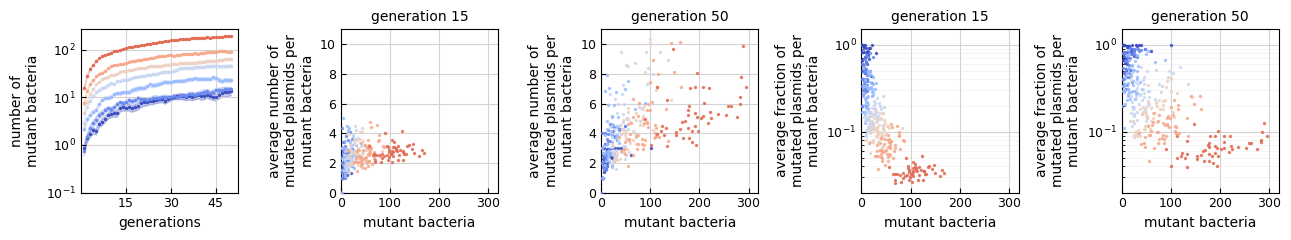

In [22]:
# model_sim.pdf
alpha_=0.3
gen_n=50
generations_=np.arange(1,gen_n+1, dtype=int)

PCN_str=['3','5','9','17','25','39','79']

color_map=colormaps['coolwarm']

#df_plasmid=df_plasmid2; u=5e-6
df_plasmid=df_plasmid7; u=2.5e-6

plt.figure(figsize=(13,2.5))
#------------------------
plt.subplot(151)
plt.yscale('log')
for i in range(0,len(PCN_str)):
    mask_=(df_plasmid[PCN_str[i]]>0).astype(int)
    # np.sum, axis=2, across population N=10000
    # np.mean, axis=0, across trials
    mean_=np.mean(np.sum(mask_,axis=2),axis=0)
    stdev_=np.std(np.sum(mask_,axis=2),axis=0)/sqrt(trials)
    plt.scatter(generations_,mean_, color=color_map(i/len(PCN_str)), label=PCN_str[i],s=2,zorder=5)
    plt.fill_between(generations_,(mean_-stdev_), (mean_+stdev_),color=color_map(i/len(PCN_str)),alpha=alpha_,zorder=1)

#y_=np.geomspace(0.1,200,30)
#plt.plot(np.ones(len(y_))*15, y_, color='darkgrey', ls='-',lw=0.5)

#legend=plt.legend(loc='lower right', fontsize=8, handlelength=1, ncols=2)
#for line in legend.get_lines():
#    line.set_linewidth(10) 
    
#for text in legend.get_texts():
#    text.set_rotation(0)
    
plt.ylabel('number of\nmutant bacteria',fontsize=10)
plt.xlabel('generations',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.xticks([15, 30, 45])
plt.minorticks_off()
plt.xlim(0, None)
plt.ylim(0.1, None)
plt.grid(True,color='lightgray',zorder=0)

gen_N_=14
#==================================================
plt.subplot(152)
for i in range(0,len(PCN_str)):
    # only for the final generation
    # df_plasmid[PCN_str[i]] structure: trials, generation, population
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
    
    mut_T=df_plasmid[PCN_str[i]][:,gen_N_,:]
    mutatedP_=np.sum(mut_T,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mutatedP_, color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

plt.title('generation '+str(gen_N_+1),fontsize=10)
plt.ylabel('average number of\nmutated plasmids per\nmutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylim([0,11])
plt.xlim([0,320])

plt.grid(True,color='lightgray',zorder=0)

gen_N_=49
#==================================================
plt.subplot(153)
#plt.yscale('log')
for i in range(0,len(PCN_str)):
    # only for the final generation
    # df_plasmid[PCN_str[i]] structure: trials, generation, population
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
    
    mut_T=df_plasmid[PCN_str[i]][:,gen_N_,:]
    mutatedP_=np.sum(mut_T,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mutatedP_, color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

plt.title('generation '+str(gen_N_+1),fontsize=10)
plt.ylabel('average number of\nmutated plasmids per\nmutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylim([0,11])
plt.xlim([0,320])

plt.grid(True,color='lightgray',zorder=0)


gen_N_=14
#==================================================
plt.subplot(154)
plt.yscale('log')
for i in range(0,len(PCN_str)):
    # only for the final generation
    # df_plasmid[PCN_str[i]] structure: trials, generation, population
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
    
    mut_T=df_plasmid[PCN_str[i]][:,gen_N_,:]
    mutatedP_=np.sum(mut_T,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mutatedP_/int(PCN_str[i]), color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

plt.title('generation '+str(gen_N_+1),fontsize=10)
plt.ylabel('average fraction of\nmutated plasmids per\nmutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylim([0.02,1.5])
plt.xlim([0,320])
plt.grid(which='major', color='lightgray',zorder=0); 
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)


gen_N_=49
#==================================================
plt.subplot(155)
plt.yscale('log')
for i in range(0,len(PCN_str)):
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
    
    mut_T=df_plasmid[PCN_str[i]][:,gen_N_,:]
    mutatedP_=np.sum(mut_T,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mutatedP_/int(PCN_str[i]), color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

plt.title('generation '+str(gen_N_+1),fontsize=10)
plt.ylabel('average fraction of\nmutated plasmids per\nmutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylim([0.02,1.5])
plt.xlim([0,320])

plt.grid(which='major', color='lightgray',zorder=0); 
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)

#===============================================
plt.tight_layout()


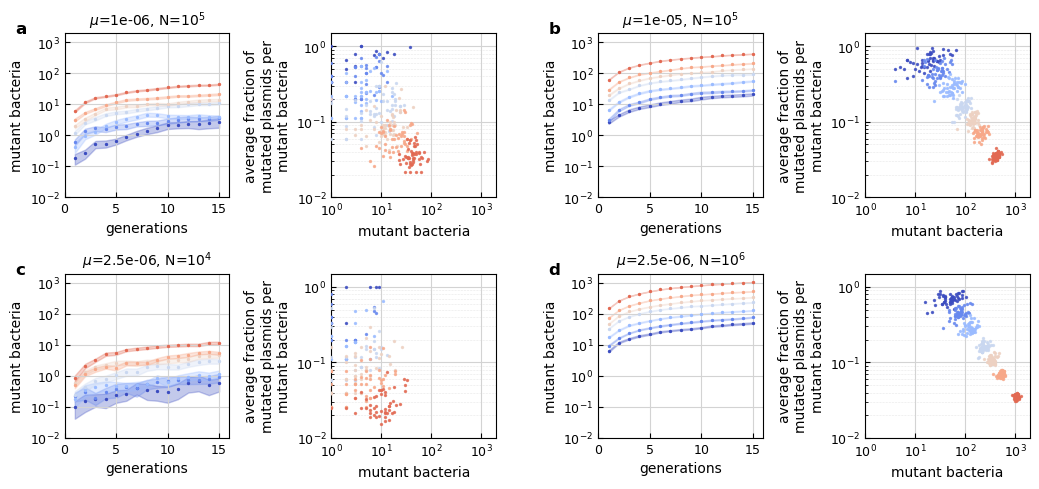

In [23]:
# model sensitivity, varying mu, varing N
alpha_=0.3; gen_n=15
generations_=np.arange(1,gen_n+1, dtype=int)

PCN_str=['3','5','9','17','25','39','79']
color_map=colormaps['coolwarm']

plt.figure(figsize=(10.5,5))

df_plasmid=df_plasmid2; u=1e-6; N=np.shape(df_plasmid['3'])[-1]
#-------------------------------
plt.subplot(241)

plt.yscale('log')
for i in range(0,len(PCN_str)):
    mask_=(df_plasmid[PCN_str[i]]>0).astype(int)
    mean_=np.mean(np.sum(mask_,axis=2),axis=0)
    stdev_=np.std(np.sum(mask_,axis=2),axis=0)/sqrt(trials)
    plt.scatter(generations_,mean_, color=color_map(i/len(PCN_str)), label=PCN_str[i],s=2,zorder=5)
    plt.fill_between(generations_,(mean_-stdev_), (mean_+stdev_),color=color_map(i/len(PCN_str)),alpha=alpha_,zorder=1)

plt.title('$\mu$='+str(u)+', N=10$^'+str(int(log10(N)))+'$',fontsize=10)
plt.ylabel('mutant bacteria',fontsize=10)
plt.xlabel('generations',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.xlim([0,16]); plt.xticks([0,5,10,15])
plt.minorticks_off()
plt.ylim(0.01, 2e3)
plt.grid(True,color='lightgray',zorder=0)
plt.minorticks_off()
plt.annotate('a',xy=(-0.3, 1), xycoords='axes fraction',fontsize=12, fontweight='bold')


gen_N_=14
#------------
plt.subplot(242)
plt.yscale('log')
plt.xscale('log')
for i in range(0,len(PCN_str)):
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
    
    mut_T=df_plasmid[PCN_str[i]][:,gen_N_,:]
    mutatedP_=np.sum(mut_T,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mutatedP_/int(PCN_str[i]), color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

plt.ylabel('average fraction of\nmutated plasmids per\nmutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylim([0.01,1.5]);
plt.xlim([1,2e3])
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.grid(which='major', color='lightgray',zorder=0);
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)

#===================================
df_plasmid=df_plasmid3; u=1e-5;N=np.shape(df_plasmid['3'])[-1]
#-------------------------------
plt.subplot(243)

plt.yscale('log')
for i in range(0,len(PCN_str)):
    mask_=(df_plasmid[PCN_str[i]]>0).astype(int)
    mean_=np.mean(np.sum(mask_,axis=2),axis=0)
    stdev_=np.std(np.sum(mask_,axis=2),axis=0)/sqrt(trials)
    plt.scatter(generations_,mean_, color=color_map(i/len(PCN_str)), label=PCN_str[i],s=2,zorder=5)
    plt.fill_between(generations_,(mean_-stdev_), (mean_+stdev_),color=color_map(i/len(PCN_str)),alpha=alpha_,zorder=1)

plt.title('$\mu$='+str(u)+', N=10$^'+str(int(log10(N)))+'$',fontsize=10)
plt.ylabel('mutant bacteria',fontsize=10)
plt.xlabel('generations',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.xlim([0,16]); plt.xticks([0,5,10,15])
plt.minorticks_off()
plt.ylim(0.01, 2e3)
plt.grid(True,color='lightgray',zorder=0)
plt.minorticks_off()
plt.annotate('b',xy=(-0.3, 1), xycoords='axes fraction',fontsize=12, fontweight='bold')

gen_N_=14
#------------
plt.subplot(244)
plt.yscale('log')
plt.xscale('log')
for i in range(0,len(PCN_str)):
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
    
    mut_T=df_plasmid[PCN_str[i]][:,gen_N_,:]
    mutatedP_=np.sum(mut_T,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mutatedP_/int(PCN_str[i]), color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

plt.ylabel('average fraction of\nmutated plasmids per\nmutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylim([0.01,1.5]);
plt.xlim([1,2e3])
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.grid(which='major', color='lightgray',zorder=0); 
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)

#================================
df_plasmid=df_plasmid6; u=2.5e-6; N=10**4

#-------------------------------
plt.subplot(245)

plt.yscale('log')
for i in range(0,len(PCN_str)):
    mask_=(df_plasmid[PCN_str[i]]>0).astype(int)
    mean_=np.mean(np.sum(mask_,axis=2),axis=0)
    stdev_=np.std(np.sum(mask_,axis=2),axis=0)/sqrt(trials)
    plt.scatter(generations_,mean_, color=color_map(i/len(PCN_str)), label=PCN_str[i],s=2,zorder=5)
    plt.fill_between(generations_,(mean_-stdev_), (mean_+stdev_),color=color_map(i/len(PCN_str)),alpha=alpha_,zorder=1)

plt.title('$\mu$='+str(u)+', N=10$^'+str(int(log10(N)))+'$',fontsize=10)
plt.ylabel('mutant bacteria',fontsize=10)
plt.xlabel('generations',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.xlim([0,16]); plt.xticks([0,5,10,15])
plt.minorticks_off()
plt.ylim(0.01, 2e3)
plt.grid(True,color='lightgray',zorder=0)
plt.minorticks_off()
plt.annotate('c',xy=(-0.3, 1), xycoords='axes fraction',fontsize=12, fontweight='bold')

gen_N_=14
#------------
plt.subplot(246)
plt.yscale('log')
plt.xscale('log')
for i in range(0,len(PCN_str)):
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
    
    mut_T=df_plasmid[PCN_str[i]][:,gen_N_,:]
    mutatedP_=np.sum(mut_T,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mutatedP_/int(PCN_str[i]), color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

plt.ylabel('average fraction of\nmutated plasmids per\nmutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylim([0.01,1.5]);
plt.xlim([1,2e3])
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.grid(which='major', color='lightgray',zorder=0); 
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)



#==================================
df_plasmid=df_plasmid8; u=2.5e-6; N=10**6

#-------------------------------
plt.subplot(247)

plt.yscale('log')
for i in range(0,len(PCN_str)):
    mask_=(df_plasmid[PCN_str[i]]>0).astype(int)
    mean_=np.mean(np.sum(mask_,axis=2),axis=0)
    stdev_=np.std(np.sum(mask_,axis=2),axis=0)/sqrt(trials)
    plt.scatter(generations_,mean_, color=color_map(i/len(PCN_str)), label=PCN_str[i],s=2,zorder=5)
    plt.fill_between(generations_,(mean_-stdev_), (mean_+stdev_),color=color_map(i/len(PCN_str)),alpha=alpha_,zorder=1)

plt.title('$\mu$='+str(u)+', N=10$^'+str(int(log10(N)))+'$',fontsize=10)
plt.ylabel('mutant bacteria',fontsize=10)
plt.xlabel('generations',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.xlim([0,16]); plt.xticks([0,5,10,15])
plt.minorticks_off()
plt.ylim(0.01, 2e3)
plt.grid(True,color='lightgray',zorder=0)
plt.minorticks_off()
plt.annotate('d',xy=(-0.3, 1), xycoords='axes fraction',fontsize=12, fontweight='bold')

gen_N_=14
#------------
plt.subplot(248)
plt.yscale('log')
plt.xscale('log')
for i in range(0,len(PCN_str)):
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
    
    mut_T=df_plasmid[PCN_str[i]][:,gen_N_,:]
    mutatedP_=np.sum(mut_T,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mutatedP_/int(PCN_str[i]), color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

plt.ylabel('average fraction of\nmutated plasmids per\nmutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylim([0.01,1.5]);
plt.xlim([1,2e3])
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.grid(which='major', color='lightgray',zorder=0); 
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)

#=============
plt.tight_layout()


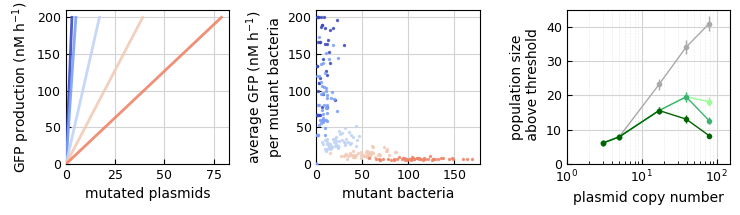

In [7]:
# IFFL_gain 
pupsp2_=200
lw_=1
color_=colormaps['coolwarm']

plt.figure(figsize=(7.5,2.25))

PCN_v=[3,5,17,39,79]

#========================
plt.subplot(131)
gfp_arr=[]
for i in range(0, len(PCN_v)):
    Np_=PCN_v[i]
    gfp_arr.append(fc.IFFL_(Np_,pupsp2_rate=pupsp2_))
    plt.plot(np.arange(0,Np_+1), gfp_arr[-1], c=color_(i/len(PCN_v)), label=str(Np_), lw=2, alpha=0.9,zorder=5)

plt.xlabel('mutated plasmids',fontsize=10)
plt.ylabel('GFP production (nM h$^{-1}$)',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)

#legend=plt.legend(loc='lower right', bbox_to_anchor=(1,0), \
#                  fontsize=8, handlelength=1, ncols=1)
#for line in legend.get_lines():
#    line.set_linewidth(5) 
    
#for text in legend.get_texts():
#    text.set_rotation(0)

plt.xlim(0,None)
plt.ylim(0,None)
plt.grid(True,color='lightgray',zorder=0)

gen_N_=14
df_plasmid=df_plasmid7

#======================
plt.subplot(132)

log_scale_=False
if log_scale_: plt.yscale('log')
PCN_str=np.array(PCN_v).astype(str)
color_map=colormaps['coolwarm']

for i in range(0,len(PCN_str)):
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials

    promoter_arr_= fc.IFFL_(PCN_v[i],pupsp2_rate=pupsp2_)
    fmut_=interp1d(np.arange(0,PCN_v[i]+1), promoter_arr_)
    mut_list=fmut_(df_plasmid[str(PCN_v[i])][:,gen_N_,:])
    GFP_=mut_list*mask_finalgen   
    mean_GFP=np.sum(GFP_,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mean_GFP, color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

plt.ylabel('average GFP (nM h$^{-1}$)\nper mutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.minorticks_off()

if log_scale_:
    y_l,y_h=(0.1,20)
    plt.ylim(y_l,y_h)
    yticks_=np.array([5,15,50])
    plt.yticks(yticks_,yticks_.astype(str))
else:
    plt.ylim(0,None)
    
plt.xlim(0,None)
plt.grid(True,color='lightgray',zorder=0)


#=======================
plt.subplot(133)
#color_=fc.color_customize(color1='darkgray', color2='darkgreen')
color_=['darkgrey','palegreen', 'mediumseagreen','darkgreen']
#--------------------------
plt.xscale('log')

if gen_N_==14: 
    threshold=np.array([6,12,14,16]) #np.linspace(10,80,8)
    th_list=threshold #np.array([10,20,30,40])

pcn_=[3,5,17,39,79]

above_thseries=np.zeros(shape=(len(pcn_),len(threshold), trials))
#-------------------
for i in range(0,len(pcn_)):
    promoter_arr_=fc.IFFL_(pcn_[i],pupsp2_rate=pupsp2_)
    fmut_=interp1d(np.arange(0,pcn_[i]+1), promoter_arr_)
    mask_finalgen=(df_plasmid[str(pcn_[i])][:,gen_N_,:]>0).astype(int)
    plasmids_=df_plasmid[str(pcn_[i])][:,gen_N_,:]
    plasmids_mut=plasmids_*mask_finalgen
    
    for t_ in range(0,len(threshold)):
        th=threshold[t_]
        series_=np.zeros(trials)
        for j in range(0,trials):
            plasmids_mut_trial=plasmids_mut[j][plasmids_mut[j]>0]
            mut_list_=fmut_(plasmids_mut_trial)
            series_[j]=len(mut_list_[mut_list_>th])
        above_thseries[i][t_,:]=series_
k=1
for th in th_list:
    i=np.where(threshold==th)[0][0]
    data_set=above_thseries[:,i,:]
    mean_=np.mean(data_set, axis=1)
    errors=np.std(data_set, axis=1)/sqrt(trials)
    plt.errorbar(pcn_, mean_, yerr= errors, fmt='-o', markersize=3, color=color_[k-1], alpha=1, linewidth=lw_, label=str(round(th,2))+' nM h$^{-1}$')

    k+=1
#-----------
#plt.legend(loc='upper left', fontsize=8)
plt.xlim([1,150])
plt.ylim(0,None)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylabel('population size\n above threshold', fontsize=10)
plt.xlabel('plasmid copy number',fontsize=10)
#plt.title('gfp deterministic', fontsize=10)
plt.grid(which='major', color='lightgray',zorder=0); plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)

#------------------
plt.tight_layout()

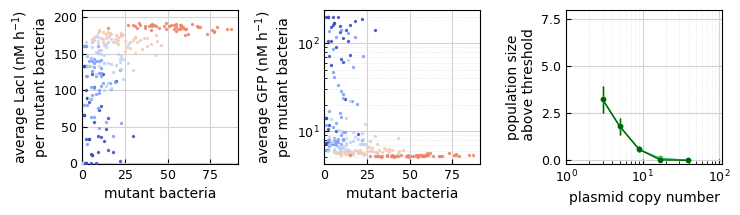

In [8]:
# IFFL_loss
r=200; Kd=5; pupsp2_=200; random.seed(10); lw_=1
# nM/h, roughly 500 moleucles

PCN_str=['3','5','9','17','39']
PCN_v=[3,5,9,17,39]

color_map=colormaps['coolwarm']
df_plasmid=df_plasmid7; u=2.5e-6

plt.figure(figsize=(7.5,2.25))

gen_N_=14
#==================================================
plt.subplot(131)
for i in range(0,len(PCN_str)):
    # df_plasmid[PCN_str[i]] structure: trials, generation, population
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials

    promoter_arr_=fc.repressor_fixedCN(r,PCN_v[i],Kd, pupsp2_rate=pupsp2_)[1]
    fmut_=interp1d(np.arange(0,PCN_v[i]+1), promoter_arr_)
    mut_list=fmut_(df_plasmid[str(PCN_v[i])][:,gen_N_,:])
    LacI_=mut_list*mask_finalgen   
    mean_LacI=np.sum(LacI_,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mean_LacI, color=color_map(i/len(PCN_str)), s=2,alpha=0.8,label=PCN_str[i],zorder=5)
    
#legend=plt.legend(loc='lower right', fontsize=8, handlelength=1, ncols=2)
#for line in legend.get_lines():
#    line.set_linewidth(10) 
    
#for text in legend.get_texts():
#    text.set_rotation(0)

#plt.title('LacI',fontsize=10)
plt.ylabel('average LacI (nM h$^{-1}$)\nper mutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.minorticks_off()
plt.ylim(-1,210)
plt.xlim(0,None)
plt.xticks([0, 25,50,75])

plt.grid(True,color='lightgray',zorder=0)

#==================================================
plt.subplot(132)
plt.yscale('log')
for i in range(0,len(PCN_str)):
    # df_plasmid[PCN_str[i]] structure: trials, generation, population
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials

    promoter_arr_=fc.repressor_fixedCN(r,PCN_v[i],Kd, pupsp2_rate=pupsp2_)[0]
    fmut_=interp1d(np.arange(0,PCN_v[i]+1), promoter_arr_)
    mut_list=fmut_(df_plasmid[str(PCN_v[i])][:,gen_N_,:])
    GFP_=mut_list*mask_finalgen   
    mean_GFP=np.sum(GFP_,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mean_GFP, color=color_map(i/len(PCN_str)), s=2,alpha=0.8, label=PCN_str[i],zorder=5)

#plt.title('GFP',fontsize=10)
plt.ylabel('average GFP (nM h$^{-1}$)\nper mutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
#plt.minorticks_off()

plt.grid(which='major', color='lightgray'); 
plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)

plt.xticks([0,25,50,75])
plt.xlim(0,None)

plt.grid(True,color='lightgray')

#================================
plt.subplot(133)
color_=['palegreen', 'mediumseagreen','darkgreen']
#--------------------------
plt.xscale('log')
dfplasmid=df_plasmid7; u=2.5e-6

if gen_N_==14: 
    threshold=np.array([14,15,16]) #np.linspace(10,80,8)
    th_list=threshold

#-------------------
pcn_=[3,5,9,17,39]
above_thseries=np.zeros(shape=(len(pcn_),len(threshold), trials))

for i in range(0,len(pcn_)):
    promoter_arr_=fc.repressor_fixedCN(r,pcn_[i],Kd,pupsp2_rate=pupsp2_)[0]
    fmut_=interp1d(np.arange(0,pcn_[i]+1), promoter_arr_)
    mask_finalgen=(df_plasmid[str(pcn_[i])][:,gen_N_,:]>0).astype(int)
    plasmids_=df_plasmid[str(pcn_[i])][:,gen_N_,:]
    plasmids_mut=plasmids_*mask_finalgen
    
    for t_ in range(0,len(threshold)):
        th=threshold[t_]
        series_=np.zeros(trials)
        for j in range(0,trials):
            plasmids_mut_trial=plasmids_mut[j][plasmids_mut[j]>0]
            mut_list_=fmut_(plasmids_mut_trial)
            series_[j]=len(mut_list_[mut_list_>th])
        above_thseries[i][t_,:]=series_
k=1
for th in th_list:
    i=np.where(threshold==th)[0][0]
    data_set=above_thseries[:,i,:]
    mean_=np.mean(data_set, axis=1)
    errors=np.std(data_set, axis=1)/sqrt(trials)
    plt.errorbar(pcn_, mean_, yerr= errors, fmt='-o', markersize=3, color=color_[k-1], alpha=1, linewidth=lw_, label=str(round(th,2))+' nM h$^{-1}$')

    k+=1
#-----------
#plt.legend(loc='upper right', fontsize=8)
#plt.xlim([1,80])
plt.xlim([1,110])

plt.ylim(None,8); plt.yticks([0,2.5,5.0,7.5])
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.ylabel('population size\n above threshold', fontsize=10)
plt.xlabel('plasmid copy number',fontsize=10)
#plt.title('gfp deterministic', fontsize=10)
plt.grid(which='major', color='lightgray'); plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray')

#----------------------
plt.tight_layout()


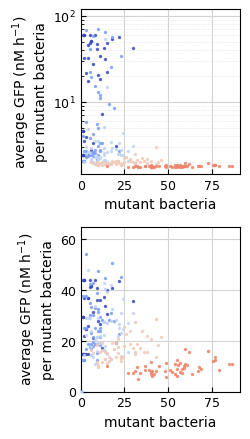

In [9]:
# regulator 
r=20; # 20 nM/h
Kd_=5;placIq_=3*r; 
reload(fc)

PCN_v=np.array([3,5,9,17,39])
PCN_str=PCN_v.astype(str)

color_map=colormaps['coolwarm']
df_plasmid=df_plasmid7; u=2.5e-6

plt.figure(figsize=(2.6,4.5))

gen_N_=14
#================================
plt.subplot(211)
plt.yscale('log')

for i in range(0,len(PCN_str)):
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials

    promoter_arr_=fc.repressormut_varyingCN(r,placIq_,PCN_v[i],Kd_)[0]
    fmut_=interp1d(np.arange(0,PCN_v[i]+1), promoter_arr_)
    mut_list=fmut_(df_plasmid[str(PCN_v[i])][:,gen_N_,:])
    GFP_=mut_list*mask_finalgen   
    mean_GFP=np.sum(GFP_,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mean_GFP, color=color_map(i/len(PCN_str)), s=2,alpha=0.8, zorder=5)

#legend=plt.legend(loc='upper right', fontsize=8, handlelength=1, ncols=2)
#for line in legend.get_lines():
#    line.set_linewidth(10) 
    
#for text in legend.get_texts():
#   text.set_rotation(0)

#plt.title('mutating lacI',fontsize=10)
plt.ylabel('average GFP (nM h$^{-1}$)\nper mutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)

plt.ylim(None,120)

plt.xticks([0,25,50,75])
plt.xlim(0,None)

plt.grid(which='major', color='lightgray',zorder=0); plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)

#------------------------------------------
plt.subplot(212)

for i in range(0,len(PCN_str)):
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
   
    promoter_arr_=fc.promotermut_varyingCN(r, placIq_, PCN_v[i], Kd=Kd_, Kd_mut=Kd_*100)[0]
    fmut_=interp1d(np.arange(0,PCN_v[i]+1), promoter_arr_)
    mut_list=fmut_(df_plasmid[str(PCN_v[i])][:,gen_N_,:])
    GFP_=mut_list*mask_finalgen   
    mean_GFP=np.sum(GFP_,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mean_GFP, color=color_map(i/len(PCN_str)), s=2,alpha=0.8, label=PCN_str[i],zorder=5)


#plt.title('mutating lacO',fontsize=10)
plt.ylabel('average GFP (nM h$^{-1}$)\nper mutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.minorticks_off()

plt.ylim(0,65); plt.yticks([0,20,40,60])
plt.xlim(0,None)
plt.xticks([0,25,50,75])

plt.grid(True,color='lightgray',zorder=0)

#=======================
plt.tight_layout()

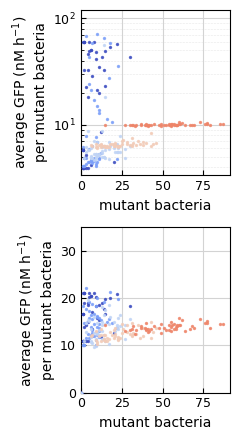

In [10]:
# feedback circuit
reload(fc)

Kd_=5; r=20; theta=0.4

PCN_v=np.array([3,5,9,17,39])
PCN_str=PCN_v.astype(str)

color_map=colormaps['coolwarm']
df_plasmid=df_plasmid7; u=2.5e-6

plt.figure(figsize=(2.5,4.5))

gen_N_=14
#================================
plt.subplot(211)
plt.yscale('log')

for i in range(0,len(PCN_str)):
    decoy_=PCN_v[i]*3
    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
    
    promoter_arr_=fc.repressormut_NF_(r,PCN_v[i],decoy_,Kd_, theta=theta)[0]
    fmut_=interp1d(np.arange(0,PCN_v[i]+1), promoter_arr_)
    mut_list=fmut_(df_plasmid[str(PCN_v[i])][:,gen_N_,:])
    GFP_=mut_list*mask_finalgen   
    mean_GFP=np.sum(GFP_,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mean_GFP, color=color_map(i/len(PCN_str)), s=2,alpha=0.8,zorder=5)

#plt.title('mutating lacI',fontsize=10)
plt.ylabel('average GFP (nM h$^{-1}$)\nper mutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)
plt.grid(which='major', color='lightgray',zorder=0); plt.grid(which='minor', linestyle=':', linewidth='0.4', color='lightgray',zorder=0)

plt.ylim(None,120)
plt.xticks([0,25,50,75])
plt.xlim(0,None)


#------------------------------------------
plt.subplot(212)

for i in range(0,len(PCN_str)):
    decoy_=PCN_v[i]*3

    mask_finalgen=(df_plasmid[PCN_str[i]][:,gen_N_,:]>0).astype(int)
    mutant_finalgen=np.sum(mask_finalgen,axis=1) # number of mutant bacteria 50 trials
   
    promoter_arr_=fc.promotermut_NF(r, PCN_v[i], decoy_, Kd_, Kd_mut=Kd_*100, theta=theta)[0]
    fmut_=interp1d(np.arange(0,PCN_v[i]+1), promoter_arr_)
    mut_list=fmut_(df_plasmid[str(PCN_v[i])][:,gen_N_,:])
    GFP_=mut_list*mask_finalgen   
    mean_GFP=np.sum(GFP_,axis=1)/(mutant_finalgen+1e-5)
    plt.scatter(mutant_finalgen, mean_GFP, color=color_map(i/len(PCN_str)), s=2,alpha=0.8, label=PCN_str[i],zorder=5)


#plt.title('mutating lacO',fontsize=10)
plt.ylabel('average GFP (nM h$^{-1}$)\nper mutant bacteria', fontsize=10)
plt.xlabel('mutant bacteria',fontsize=10)
plt.tick_params(direction='in',which='both',axis='both',labelsize=9)

plt.ylim(0,35); plt.yticks([0,10,20,30])
plt.xlim(0,None)
plt.xticks([0,25,50,75])

plt.grid(True,color='lightgray',zorder=0)

#=======================
plt.tight_layout()